In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'Deep_learning_kursus/assignments/assignment1/' such 
#that e.g.: FOLDERNAME = 'Deep_learningE22/assignments/assignment1/'

FOLDERNAME = None
FOLDERNAME = 'Deep_learningE22/assignments/'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


# Softmax exercise

*Complete this exercise and enclude results and output graphs along with desribtions of the model and development method in the assignment submission.

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del HAM_train_data
   del HAM_val_data
   del HAM_test_data
   print('Clear previously loaded data.')
except:
   pass


# Load the training and tuning datasets.
%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/HAM_modified/
HAM_train_data = np.load('HAM_train.npz',allow_pickle=True)
HAM_val_data = np.load('HAM_val.npz',allow_pickle=True)
HAM_test_data = np.load('HAM_test.npz',allow_pickle=True)
%cd /content/drive/My\ Drive/$FOLDERNAME

#load and print header to view some info on the data and example data
header = HAM_train_data['header']
print('\n')
print(header)
print('\n')
print(HAM_train_data['images'][0].shape,HAM_train_data['meta'][0][:],'label: ',HAM_train_data['labels'][0])
print('\n')
X_train, y_train, train_meta = HAM_train_data['images'], HAM_train_data['labels'], HAM_train_data['meta']

X_val, y_val, val_meta = HAM_val_data['images'], HAM_val_data['labels'], HAM_val_data['meta']

X_test, y_test, test_meta = HAM_test_data['images'], HAM_test_data['labels'], HAM_test_data['meta']


# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Training meta info shape: ', train_meta.shape)
print('\n')
print('Val data shape: ', X_val.shape)
print('Val labels shape: ', y_val.shape)
print('Val meta info shape: ', val_meta.shape)
print('\n')
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Test meta info shape: ', test_meta.shape)

/content/drive/My Drive/Deep_learningE22/assignments/datasets/HAM_modified
/content/drive/My Drive/Deep_learningE22/assignments


['image_array' 'image_id' 'dx' 'dx_type' 'age' 'sex' 'localization']


(48, 48, 3) ['ISIC_0028005' 'nv' 'follow_up' '45.0' 'male' 'trunk'] label:  2.0


Training data shape:  (13932, 48, 48, 3)
Training labels shape:  (13932,)
Training meta info shape:  (13932, 6)


Val data shape:  (2821, 48, 48, 3)
Val labels shape:  (2821,)
Val meta info shape:  (2821, 6)


Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Test meta info shape:  (2866, 6)


Number of classes = 3


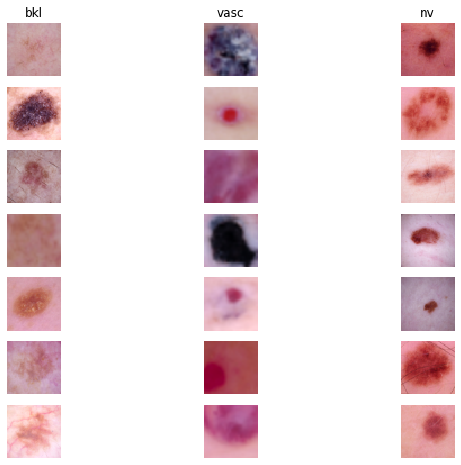

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
# we are going to be classifying three different types of 
# skin lesion on images sampled and modified from the HAM10000 data-set:
# https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T 


class_dict = {'bkl':'benign keratosis-like lesions', 
               'vasc':'vascular lesions', 
               'nv':'melanocytic nevi'}


num_classes = len(class_dict.keys())

print('Number of classes = {}'.format(num_classes))

samples_per_class = 7
for y, cls in enumerate(class_dict.keys()):
    idxs = np.where(train_meta[:] == cls)[0]
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# The data is alreade split the into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.

num_dev = 500

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(X_train.shape[0], num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]


print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)

Train data shape:  (13932, 48, 48, 3)
Train labels shape:  (13932,)
Validation data shape:  (2821, 48, 48, 3)
Validation labels shape:  (2821,)
Test data shape:  (2866, 48, 48, 3)
Test labels shape:  (2866,)
Dev data shape:  (500, 48, 48, 3)
Dev labels shape:  (500,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (13932, 6912)
Validation data shape:  (2821, 6912)
Test data shape:  (2866, 6912)
dev data shape:  (500, 6912)


[192.56496 144.48407 155.54823 193.51831 145.14003 156.4786  194.35071
 145.6503  157.23729 195.01694]


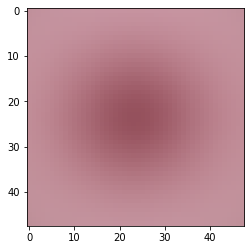

(13932, 6913) (2821, 6913) (2866, 6913) (500, 6913)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((48,48,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `classifiers/softmax.py`.


In [9]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(6913, 3) * 0.0001 
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.33).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.33)))

loss: 1.092556
sanity check: 1.108663


**Inline Question**

Include in the report why we expect our loss to be close to -log(0.33)? Explain briefly.**



In [10]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from classifiers.Deep_learning_course.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 3.647645 analytic: 3.647646, relative error: 2.644930e-08
numerical: 2.803252 analytic: 2.803252, relative error: 1.025016e-08
numerical: 0.531673 analytic: 0.531673, relative error: 8.821359e-08
numerical: -3.892380 analytic: -3.892380, relative error: 9.515793e-09
numerical: -4.905948 analytic: -4.905948, relative error: 6.309549e-09
numerical: -0.776011 analytic: -0.776011, relative error: 2.315168e-09
numerical: -1.291724 analytic: -1.291724, relative error: 1.381017e-09
numerical: -0.331343 analytic: -0.331343, relative error: 6.136713e-08
numerical: 2.369473 analytic: 2.369473, relative error: 1.312181e-08
numerical: 1.204196 analytic: 1.204196, relative error: 1.099462e-08
numerical: 0.587689 analytic: 0.587689, relative error: 4.145007e-08
numerical: -4.373158 analytic: -4.373158, relative error: 6.109167e-09
numerical: -0.050613 analytic: -0.050613, relative error: 3.385603e-07
numerical: 1.232560 analytic: 1.232560, relative error: 2.450238e-08
numerical: -1.031242

In [25]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))
print('Naive gradient: '.format(grad_naive))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))
print('Vectorized gradient: '.format(grad_vectorized))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 1.092556e+00 computed in 0.027209s
Naive gradient: 
vectorized loss: 1.092556e+00 computed in 0.022941s
Vectorized gradient: 
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths.

from classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in range(128):
    learning_rate = np.power(10, np.random.uniform(-6.6, -6.1))
    reg = np.power(10, np.random.uniform(4.0, 4.7))
    y_train = y_train.astype(int)
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=learning_rate,
                              reg=reg, num_iters=300, batch_size=200,
                              verbose=False)
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train_pred == y_train)
    y_val_pred   = softmax.predict(X_val)
    val_accuracy = np.mean(y_val_pred == y_val)

    if best_val < val_accuracy:
        best_val = val_accuracy
        best_softmax = softmax

    results[(learning_rate, reg)] = (train_accuracy, val_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 2.530847e-07 reg 3.073853e+04 train accuracy: 0.729400 val accuracy: 0.731655
lr 2.533625e-07 reg 1.411656e+04 train accuracy: 0.749928 val accuracy: 0.759305
lr 2.545050e-07 reg 3.135333e+04 train accuracy: 0.721935 val accuracy: 0.726338
lr 2.574292e-07 reg 3.361402e+04 train accuracy: 0.719997 val accuracy: 0.734137
lr 2.581191e-07 reg 3.238797e+04 train accuracy: 0.709805 val accuracy: 0.719248
lr 2.604953e-07 reg 1.867750e+04 train accuracy: 0.736649 val accuracy: 0.741935
lr 2.642667e-07 reg 1.380706e+04 train accuracy: 0.742176 val accuracy: 0.753988
lr 2.660753e-07 reg 2.252457e+04 train accuracy: 0.735860 val accuracy: 0.750798
lr 2.684632e-07 reg 3.874681e+04 train accuracy: 0.705785 val accuracy: 0.701879
lr 2.690105e-07 reg 1.272979e+04 train accuracy: 0.742894 val accuracy: 0.755406
lr 2.703457e-07 reg 3.386654e+04 train accuracy: 0.728754 val accuracy: 0.741227
lr 2.767614e-07 reg 2.488252e+04 train accuracy: 0.729687 val accuracy: 0.733428
lr 2.782462e-07 reg 4.945721

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.762736


**Inline Question** 

Consider the following. Include in your report if you think it adds value:

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.



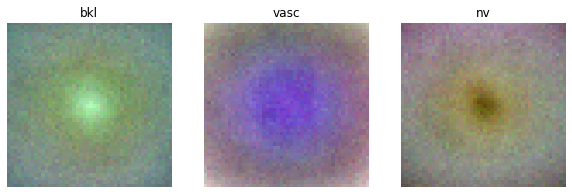

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(48, 48, 3, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['bkl', 'vasc','nv']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline Question**

In the report, describe what your visualized weights look like, and offer a brief explanation for why they look the way they do in comparisson to the SVM weights.
